# Ensemble/Voting Classification in Python with Scikit-Learn
ref：https://www.kaggle.com/c/titanic/submit

In [14]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

In [2]:
training_data = pd.read_csv('data/train.csv')
testing_data = pd.read_csv('data/test.csv')

def get_nulls(training, testing):
    print("Training Data:")
    print(pd.isnull(training).sum())
    print("Testing Data:")
    print(pd.isnull(testing).sum())

get_nulls(training_data, testing_data)

Training Data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [3]:
# Drop the cabin column, as there are too many missing values
# Drop the ticket numbers too, as there are too many categories
# Drop names as they won't really help predict survivors
training_data.drop(['Cabin', 'Ticket', 'Name'], axis = 1, inplace = True)
testing_data.drop(['Cabin', 'Ticket', 'Name'], axis = 1, inplace = True)

# Taking the mean/average value would be impacted by the skew
# so we should use the median value to impute missing values
training_data["Age"].fillna(training_data["Age"].median(), inplace=True)
testing_data["Age"].fillna(testing_data["Age"].median(), inplace=True)
training_data["Embarked"].fillna("S", inplace=True)
testing_data["Fare"].fillna(testing_data['Fare'].median(), inplace=True)

get_nulls(training_data, testing_data)

Training Data:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Testing Data:
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


In [4]:
# Fit the encoder on the data (Feature: Sex)
encoder_1 = LabelEncoder()
encoder_1.fit(training_data["Sex"])

# Transform and replace training data
training_sex_encoded = encoder_1.transform(training_data["Sex"])
training_data["Sex"] = training_sex_encoded
test_sex_encoded = encoder_1.transform(testing_data["Sex"])
testing_data["Sex"] = test_sex_encoded

# Fit the encoder on the data (Feature: Embarked)
encoder_2 = LabelEncoder()
encoder_2.fit(training_data["Embarked"])

training_data['Embarked'] = encoder_2.transform(training_data['Embarked'])
testing_data['Embarked'] = encoder_2.transform(testing_data['Embarked'])

In [5]:
# Any value we want to reshape needs be turned into array first
ages_train = np.array(training_data["Age"]).reshape(-1, 1)
ages_test = np.array(testing_data["Age"]).reshape(-1, 1)

fare_train = np.array(training_data['Fare']).reshape(-1, 1)
fare_test = np.array(testing_data['Fare']).reshape(-1, 1)

# Scaler takes arrays
scaler = StandardScaler()

training_data["Age"] = scaler.fit_transform(ages_train)
testing_data["Age"] = scaler.fit_transform(ages_test)

training_data['Fare'] = scaler.fit_transform(fare_train)
testing_data['Fare'] = scaler.fit_transform(fare_test)

In [6]:
# Now to select our training/testing data
X_features = training_data.drop(labels=['PassengerId', 'Survived'], axis=1)
y_labels = training_data['Survived']

print(X_features.head(5))
print(y_labels.head(5))

# Make the train/test data from validation

X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.1,random_state=12)

   Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
0       3    1 -0.565736      1      0 -0.502445         2
1       1    0  0.663861      1      0  0.786845         0
2       3    0 -0.258337      0      0 -0.488854         2
3       1    0  0.433312      1      0  0.420730         2
4       3    1  0.433312      0      0 -0.486337         2
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


## Simple Averaging Approach

In [7]:
LogReg_clf = LogisticRegression()
DTree_clf = DecisionTreeClassifier()
SVC_clf = SVC()

LogReg_clf.fit(X_train, y_train)
DTree_clf.fit(X_train, y_train)
SVC_clf.fit(X_train, y_train)

LogReg_pred = LogReg_clf.predict(X_val)
DTree_pred = DTree_clf.predict(X_val)
SVC_pred = SVC_clf.predict(X_val)

averaged_preds = (LogReg_pred + DTree_pred + SVC_pred)//3
acc = accuracy_score(y_val, averaged_preds)
print(acc)

0.8


## Bagging Classification Example

In [8]:
logreg_bagging_model = BaggingClassifier(base_estimator = LogReg_clf, n_estimators = 50, random_state = 12)
dtree_bagging_model = BaggingClassifier(base_estimator = DTree_clf, n_estimators = 50, random_state = 12)
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12)
extra_trees = ExtraTreesClassifier(n_estimators = 100, random_state = 12)

def bagging_ensemble(model):
    k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
    results = cross_val_score(model, X_train, y_train, cv=k_folds)
    #print(results.mean()) 
    return results.mean()

print("Logistic Regression :", bagging_ensemble(logreg_bagging_model))
print("Decision Tree       :", bagging_ensemble(dtree_bagging_model))
print("Random Forest       :", bagging_ensemble(random_forest))
print("Extra Tree          :", bagging_ensemble(extra_trees))

Logistic Regression : 0.7927134146341464
Decision Tree       : 0.8188719512195123
Random Forest       : 0.8113719512195123
Extra Tree          : 0.7963719512195122


## Boosting Classification Example

In [13]:
k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
num_estimators = [20, 40, 60, 80, 100]

for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators = i, random_state = 12) 
    results = cross_val_score(ada_boost, X_train, y_train, cv=k_folds)
    print("Results for {} estimators:".format(i))
    print(results.mean())


Results for 20 estimators:
0.8052134146341464
Results for 40 estimators:
0.8176524390243903
Results for 60 estimators:
0.8164329268292683
Results for 80 estimators:
0.8151524390243902
Results for 100 estimators:
0.8101524390243903


In [20]:

k_folds = KFold(n_splits=20, random_state=12,shuffle=True)
# num_estimators = [20, 40, 60, 80, 100]
num_estimators = range(20, 101, 1)

score_result = []

for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators = i, random_state = 12) 
    results = cross_val_score(ada_boost, X_train, y_train, cv=k_folds)
    # print("Results for {} estimators:".format(i))
    # print(results.mean())
    score_result.append(results.mean())
    

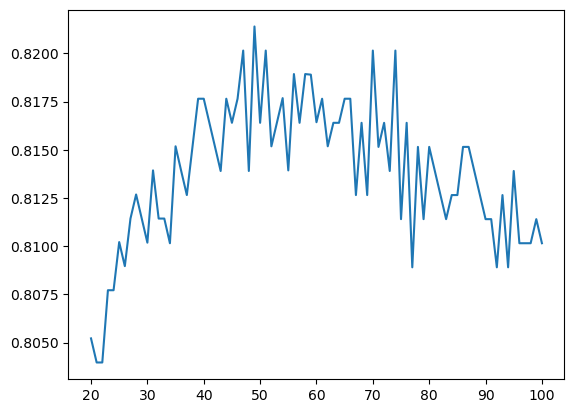

In [21]:
plt.plot(num_estimators, score_result)
# num_estimator 為 49 左右時, 準確度最佳, 可達 0.82 以上

In [28]:
ada_boost = AdaBoostClassifier(n_estimators = 49, random_state = 12) 
results = cross_val_score(ada_boost, X_train, y_train, cv=k_folds)
print("Results for {} estimators:".format(i))
print(results.mean())

Results for 100 estimators:
0.8214024390243901


## voting\Stacking Classification Example

In [70]:
voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf)], voting='hard')
voting_clf.fit(X_train, y_train)
preds = voting_clf.predict(X_val)
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

# 套用至 testing data , 上傳 Kaggle , score = 0.7799

Accuracy is: 0.8333333333333334
Log Loss is: 5.756516038980461
F1 Score is: 0.7761194029850748


In [72]:
# soft voting
SVC_clf_probTrue = SVC(probability = True)

voting_clf_soft = VotingClassifier(estimators=[('SVC', SVC_clf_probTrue), ('DTree', DTree_clf), ('LogReg', LogReg_clf)], voting='soft')
voting_clf_soft.fit(X_train, y_train)
preds = voting_clf_soft.predict(X_val)
acc = accuracy_score(y_val, preds)
l_loss = log_loss(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

# 套用至 testing data , 上傳 Kaggle , score = 0.77272

Accuracy is: 0.8666666666666667
Log Loss is: 4.605196839235765
F1 Score is: 0.8125


## Prepare to submit to Kaggle

In [76]:
testing_pred = voting_clf.predict(testing_data.drop(['PassengerId'], axis = 1))

In [77]:
testing_pred = pd.DataFrame(testing_pred, columns = ['Survived'])
testing_pred_result = pd.concat([testing_data['PassengerId'], testing_pred], axis = 1)
testing_pred_result.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [78]:
testing_pred_result.to_csv('titanic_kaggle_submission.csv', index = False)